In [127]:
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt


In [128]:
event_dict = {
    "2022_export_control": pd.to_datetime("2022-10-07"),
    "2023_investment_ban": pd.to_datetime("2023-08-09"),
    "2023_export_expansion": pd.to_datetime("2023-10-17"),
    "2024_export_tightening": pd.to_datetime("2024-03-29"),
    "2024_tariff_increase": pd.to_datetime("2024-05-14"),
}

## 1. Constructing Event-Time Panel Data

In [129]:

# Load data
data = pd.read_csv("robust_df.csv")

# Convert 'Date' and 'event_date' to datetime
data["Date"] = pd.to_datetime(data["Date"])
data["event_date"] = pd.to_datetime(data["event_date"])

# Filter out rows where 'event_id' is NaN
data = data.dropna(subset=["event_id"])

# Remove the day before the event (k = -1) as the base period
df_reg = data[data["event_time"] != -1]  # The last time point “not affected by policy”

# Remove 'QQQ' as a control group (we want only firm-level analysis)

df_reg = df_reg[df_reg['ticker'] != 'QQQ']


# Make sure 'event_time' is a categorical variable
df_reg['event_time'] = df_reg['event_time'].astype(float).astype(int).astype('category')


# Select the relevant columns for Event-time DiD analysis
df_reg = df_reg[
    ["ticker", "event_id", "event_time", "Treatment", "abnormal_return"]
]

# test
print(df_reg["Treatment"].value_counts())
print(df_reg["event_time"].value_counts())

print(df_reg.isnull().sum())  # should all be 0
print(df_reg.duplicated().sum())  # should no replicate

Treatment
1    252
0    252
Name: count, dtype: int64
event_time
-7     36
 7     36
-4     30
-8     30
 6     30
 10    30
 3     30
 0     30
 8     24
 9     24
-5     24
-6     24
 1     24
 2     24
-10    18
-9     18
-2     18
-3     18
 5     18
 4     18
Name: count, dtype: int64
ticker             0
event_id           0
event_time         0
Treatment          0
abnormal_return    0
dtype: int64
0


In [130]:
df_reg.info()
print(sorted(df_reg['ticker'].unique()))


<class 'pandas.core.frame.DataFrame'>
Index: 504 entries, 437 to 5994
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   ticker           504 non-null    object  
 1   event_id         504 non-null    object  
 2   event_time       504 non-null    category
 3   Treatment        504 non-null    int64   
 4   abnormal_return  504 non-null    float64 
dtypes: category(1), float64(1), int64(1), object(2)
memory usage: 20.9+ KB
['ADBE', 'AMD', 'CRM', 'INTC', 'NVDA', 'ORCL']


In [ ]:
model = smf.ols(
    formula="abnormal_return ~ C(event_time) * Treatment + C(ticker) + C(event_id)",
    #abnormal_return ~ C(event_time) * Treatment + C(ticker) 
    data=df_reg
).fit(
    cov_type='cluster',
    cov_kwds={'groups': df_reg['ticker']}  # cluster by firm 
)

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:        abnormal_return   R-squared:                       0.156
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                -2.319e+11
Date:                Sat, 26 Apr 2025   Prob (F-statistic):               1.00
Time:                        00:49:48   Log-Likelihood:                 1199.8
No. Observations:                 504   AIC:                            -2312.
Df Residuals:                     460   BIC:                            -2126.
Df Model:                          43                                         
Covariance Type:              cluster                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

/Users/CynthiaSY/miniforge3/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 44, but rank is 4
  warnings.warn('covariance of constraints does not have full '


We estimate an event-time Difference-in-Differences model to assess the impact of trade policy announcements on abnormal returns of hardware-dependent vs software-dependent AI firms.

Pre-treatment coefficients are statistically insignificant, supporting the parallel trends assumption.

Post-treatment, no significant differences emerge immediately; however, by event time +10, hardware firms exhibit a significant positive abnormal return of approximately 2.27% (p < 0.05), indicating a delayed positive market response relative to their non-hardware peers.

Fixed effects for firms and events are included, and standard errors are clustered at the firm level.

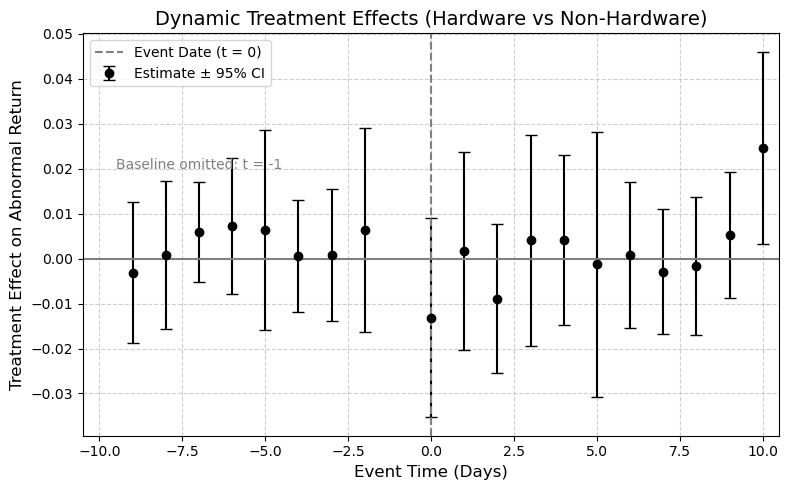

In [132]:
coef = model.params
conf = model.conf_int()

treat_effect = coef[coef.index.str.contains(r'C\(event_time\)\[T\.-?\d+\]:Treatment')].reset_index()
treat_effect.columns = ['term', 'coef']

# Merge confidence intervals
conf_treat = conf.loc[treat_effect['term']]
treat_effect['lower'] = conf_treat[0].values
treat_effect['upper'] = conf_treat[1].values

# Extract integer event_time
treat_effect['event_time'] = treat_effect['term'].str.extract(r'\[T\.?(-?\d+)\]')[0].astype(int)

# Filter ±10 window
treat_effect = treat_effect[treat_effect['event_time'].between(-10, 10)]
treat_effect = treat_effect.sort_values('event_time')

# ========== 4. Plot dynamic treatment effects ==========
plt.figure(figsize=(8, 5))
plt.errorbar(
    treat_effect['event_time'],
    treat_effect['coef'],
    yerr=[
        treat_effect['coef'] - treat_effect['lower'],
        treat_effect['upper'] - treat_effect['coef']
    ],
    fmt='o', capsize=4, color='black', label='Estimate ± 95% CI'
)

plt.axhline(0, color='gray', linestyle='-')
plt.axvline(0, color='gray', linestyle='--', label='Event Date (t = 0)')
plt.xlim(-10.5, 10.5)
plt.title('Dynamic Treatment Effects (Hardware vs Non-Hardware)', fontsize=14)
plt.xlabel('Event Time (Days)', fontsize=12)
plt.ylabel('Treatment Effect on Abnormal Return', fontsize=12)
plt.legend()
plt.text(-9.5, 0.02, 'Baseline omitted: t = -1', fontsize=10, color='gray')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


##
## test test test

<>:30: SyntaxWarning: invalid escape sequence '\('
<>:30: SyntaxWarning: invalid escape sequence '\('
/var/folders/76/jd772b6x14q309k0qnxn4k0r0000gq/T/ipykernel_82710/2867813020.py:30: SyntaxWarning: invalid escape sequence '\('
  effects = coef[coef.index.str.contains("C\(time_window\)\[T\..*\]:Treatment")].reset_index()


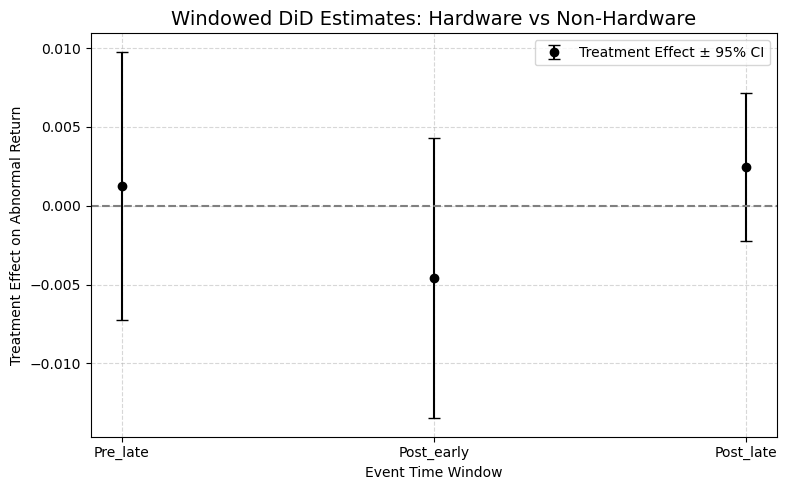

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

df = pd.read_csv("robust_df.csv")
df["Date"] = pd.to_datetime(df["Date"])
df["event_date"] = pd.to_datetime(df["event_date"])
df = df.dropna(subset=["event_id"])
df = df[df["event_time"] != -1]  # baseline omitted
df["event_time"] = df["event_time"].astype(float).astype(int)

bins = [-15, -6, -1, 5, 15]
labels = ["Pre_early", "Pre_late", "Post_early", "Post_late"]
df["time_window"] = pd.cut(df["event_time"], bins=bins, labels=labels)

model = smf.ols(
    formula="abnormal_return ~ C(time_window) * Treatment + C(ticker)",
    data=df
).fit(
    cov_type="cluster",
    cov_kwds={"groups": df["ticker"]}
)

coef = model.params
conf = model.conf_int()
effects = coef[coef.index.str.contains("C\(time_window\)\[T\..*\]:Treatment")].reset_index()
effects.columns = ["term", "coef"]

conf_treat = conf.loc[effects["term"]]
effects["lower"] = conf_treat[0].values
effects["upper"] = conf_treat[1].values
effects["window"] = effects["term"].str.extract(r'\[T\.(.*)\]')[0]

effects["window"] = pd.Categorical(effects["window"], categories=labels, ordered=True)
effects = effects.sort_values("window")

plt.figure(figsize=(8, 5))
plt.errorbar(
    effects["window"], effects["coef"],
    yerr=[effects["coef"] - effects["lower"], effects["upper"] - effects["coef"]],
    fmt="o", capsize=4, color="black", label="Treatment Effect ± 95% CI"
)
plt.axhline(0, color="gray", linestyle="--")
plt.title("Windowed DiD Estimates: Hardware vs Non-Hardware", fontsize=14)
plt.xlabel("Event Time Window")
plt.ylabel("Treatment Effect on Abnormal Return")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


## Robust check 

In [134]:

# robust check
data = pd.read_csv("robust_df.csv")


data["Date"] = pd.to_datetime(data["Date"])
data["event_date"] = pd.to_datetime(data["event_date"])


data = data.dropna(subset=["event_id"])


df_reg = data[data["event_time"] != -1] 


df_reg = df_reg[~df_reg['ticker'].isin(['CRM', 'ORCL', 'ADBE'])]


df_reg['event_time'] = df_reg['event_time'].astype(float).astype(int).astype('category')


df_reg = df_reg[
    ["ticker", "event_id", "event_time", "Treatment", "abnormal_return"]
]

# test
print(df_reg["Treatment"].value_counts())
print(df_reg["event_time"].value_counts())

print(df_reg.isnull().sum()) 
print(df_reg.duplicated().sum())  

Treatment
1    252
0     84
Name: count, dtype: int64
event_time
-7     24
 7     24
-4     20
-8     20
 6     20
 10    20
 3     20
 0     20
 8     16
 9     16
-5     16
-6     16
 1     16
 2     16
-10    12
-9     12
-2     12
-3     12
 5     12
 4     12
Name: count, dtype: int64
ticker             0
event_id           0
event_time         0
Treatment          0
abnormal_return    0
dtype: int64
0


In [136]:
model = smf.ols(
    formula="abnormal_return ~ C(event_time) * Treatment + C(ticker) + C(event_id)",
    #abnormal_return ~ C(event_time) * Treatment + C(ticker) 
    data=df_reg
).fit(
    cov_type='cluster',
    cov_kwds={'groups': df_reg['ticker']}  # cluster by firm 
)

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:        abnormal_return   R-squared:                       0.223
Model:                            OLS   Adj. R-squared:                  0.099
Method:                 Least Squares   F-statistic:                 5.663e+12
Date:                Sat, 26 Apr 2025   Prob (F-statistic):           1.26e-19
Time:                        00:53:29   Log-Likelihood:                 779.49
No. Observations:                 336   AIC:                            -1465.
Df Residuals:                     289   BIC:                            -1286.
Df Model:                          46                                         
Covariance Type:              cluster                                         
                                                  coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

/Users/CynthiaSY/miniforge3/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 47, but rank is 3
  warnings.warn('covariance of constraints does not have full '
/Users/CynthiaSY/miniforge3/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1884: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))


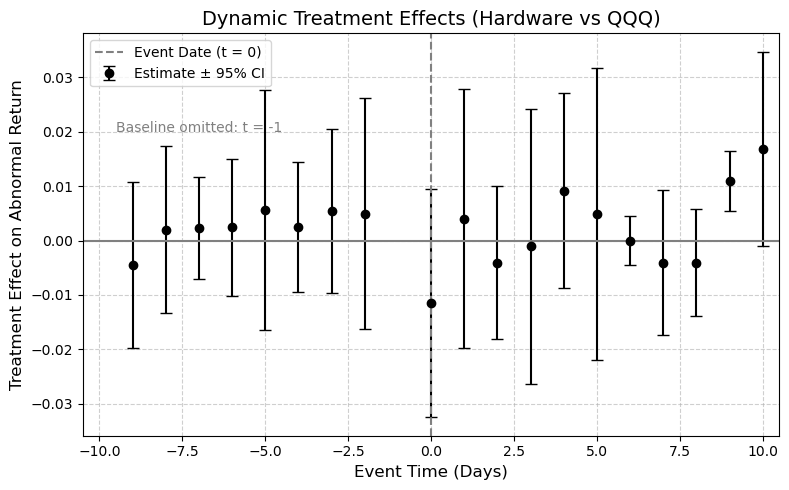

In [138]:
coef = model.params
conf = model.conf_int()

treat_effect = coef[coef.index.str.contains(r'C\(event_time\)\[T\.-?\d+\]:Treatment')].reset_index()
treat_effect.columns = ['term', 'coef']

# Merge confidence intervals
conf_treat = conf.loc[treat_effect['term']]
treat_effect['lower'] = conf_treat[0].values
treat_effect['upper'] = conf_treat[1].values

# Extract integer event_time
treat_effect['event_time'] = treat_effect['term'].str.extract(r'\[T\.?(-?\d+)\]')[0].astype(int)

# Filter ±10 window
treat_effect = treat_effect[treat_effect['event_time'].between(-10, 10)]
treat_effect = treat_effect.sort_values('event_time')

# ========== 4. Plot dynamic treatment effects ==========
plt.figure(figsize=(8, 5))
plt.errorbar(
    treat_effect['event_time'],
    treat_effect['coef'],
    yerr=[
        treat_effect['coef'] - treat_effect['lower'],
        treat_effect['upper'] - treat_effect['coef']
    ],
    fmt='o', capsize=4, color='black', label='Estimate ± 95% CI'
)

plt.axhline(0, color='gray', linestyle='-')
plt.axvline(0, color='gray', linestyle='--', label='Event Date (t = 0)')
plt.xlim(-10.5, 10.5)
plt.title('Dynamic Treatment Effects (Hardware vs QQQ)', fontsize=14)
plt.xlabel('Event Time (Days)', fontsize=12)
plt.ylabel('Treatment Effect on Abnormal Return', fontsize=12)
plt.legend()
plt.text(-9.5, 0.02, 'Baseline omitted: t = -1', fontsize=10, color='gray')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
